On définit le jour 25/01 comme le jour 0. Alors, on a :

|date|jour|
|---|---|
|25/01|0|
|24/02|30|
|15/03|50|

In [2]:
import numpy as np
from scipy.integrate import solve_ivp 
import matplotlib.pyplot as plt
np.random.seed(0)

In [3]:
class SEIR():
    def __init__(self, params=None):
        d0 = np.datetime64('2020-01-25')
        self.T_end = np.datetime64("2020-05-11")
        self.d0 = d0
        S0=67e6
        self.S0 = S0
        self.reset(params)
    
    def reset(self, params=None):
        if params is not None:
            x = params
            # Probability for different evenements
            self.p_a = x[0]
            self.p_IH = x[1]
            self.p_IU = x[2]
            self.p_HD = x[3]
            self.p_HU = x[4]
            self.p_UD = x[5]

            # number of days passed in different phase
            self.N_I = x[6]
            self.N_H = x[7]
            self.N_U = x[8]

            self.R0 = x[9]       # Reproduction rate of coronavirus
            self.mu = x[10]      # Decline rate of transmission
            self.N = x[11]          # The beginning date of the quarantine

            self.t0 = x[12]          # The beginning date of the epidemie
            self.I_minus = x[13]     # The number of infected person at the beginning
            self.lamb1 = x[14]   # positive rate for the test 1 in the differentiel equation
            self.lamb2 = 0
        else:
        #########################################################################
        ############## We reset the variables with the uniform law ##############
        #########################################################################
        # Probability for different evenements
            self.p_a = np.random.uniform(0.4, 0.9)
            self.p_IH = np.random.uniform(0.05, 0.2)
            self.p_IU = np.random.uniform(0.01, 0.04)
            self.p_HD = np.random.uniform(0.1, 0.2)
            self.p_HU = np.random.uniform(0.1, 0.2)
            self.p_UD = np.random.uniform(0.2, 0.4)

            # number of days passed in different phase
            self.N_I = np.random.uniform(8, 12)
            self.N_H = np.random.uniform(15, 25)
            self.N_U = np.random.uniform(10, 20)


            self.R0 = np.random.uniform(2.9, 3.4)        # Reproduction rate of coronavirus
            self.mu = np.random.uniform(0.01, 0.08)      # Decline rate of transmission
            self.N = np.random.randint(30, 50)           # The beginning date of the quarantine

            self.t0 = np.random.randint(0, 31)           # The beginning date of the epidemie
            self.I_minus = np.random.uniform(1, 100)     # The number of infected person at the beginning
            self.lamb1 = np.random.uniform(1e-4, 1e-3)   # positive rate for the test 1 in the differentiel equation
            self.lamb2 = 0                               # positive rate for the test 2 in the differentiel equation

        #########################################################################
        ############ The coefficients in the differentiel equations #############
        #########################################################################
        variables = np.ones(9)

        variables[1] = (self.p_a+(1-self.p_a)*(1-self.p_IH-self.p_IU))/self.N_I          # gamma_IR
        variables[2] = (1-self.p_a)*self.p_IH/self.N_I                    # gamma_IH
        variables[3] = (1-self.p_a)*self.p_IU/self.N_I                    # gamma_IU
        
        variables[4] = self.p_HD/self.N_H                                 # gamma_HD
        variables[5] = self.p_HU/self.N_H                                 # gamma_HU
        variables[6] = (1-self.p_HD-self.p_HU)/self.N_H                   # gamma_HR
        
        variables[7] = self.p_UD/self.N_U                                 # gamma_UD
        variables[8] = (1-self.p_UD)/self.N_U                             # gamma_UR
        
        variables[0] = self.R0*(self.lamb1+variables[1]+variables[2]+variables[3])/self.S0
                                                            # tau0, the transmission rate at the beginning
        
        self.variables = np.copy(variables)
        
        #########################################################################
        ################### Population in different blocs #######################
        #########################################################################
        # We modelize the population with type S, I-, I+, R-, R+I, H, U, R+H, D, DR
        # To a vector.
        self.population = np.zeros(10)
        self.population[0] = self.S0                        # S_0 = 67
        self.population[1] = self.I_minus                   # I- in [1, 100] randomly
        return

    def params(self):
        x = np.array([self.p_a, self.p_IH, self.p_IU,
                     self.p_HD, self.p_HU, self.p_UD,
                     self.N_I, self.N_H, self.N_U,
                     self.R0, self.mu, self.N,
                     self.t0, self.I_minus, self.lamb1])
        return x
    
    def evolution_dt(self, t, population):
        derivee = np.zeros(10)
        
        ####### Initialisation of different variables #######
        # Population
        S, I_minus, I_plus, R_minus, R_I, H, U, R_H, D, DR = population
        # Variables
        (tau0, 
         gamma_IR, gamma_IH, gamma_IU,
         gamma_HD, gamma_HU, gamma_HR, 
         gamma_UD, gamma_UR) = self.variables
        
        # tau at time t
        tau = tau0*np.exp(-self.mu*max(t-self.N, 0))
        
        # dX/dt for X = S, I-, I+, R-, R+I, H, U, R+H, D
        derivee[0] = -tau*S*I_minus                                                 #dS/dt
        derivee[1] = (tau*S - self.lamb1 - (gamma_IR+gamma_IH+gamma_IU))*I_minus         #dI_minus/dt
        derivee[2] = self.lamb1*I_minus - (gamma_IR+gamma_IH+gamma_IU)*I_plus            #dI_plus/dt
        derivee[3] = gamma_IR*I_minus - self.lamb2*R_minus                               #dR_minus/dt
        derivee[4] = gamma_IR*I_plus + self.lamb2*R_minus                                #dR_I/dt
        derivee[5] = gamma_IH*(I_minus+I_plus) - (gamma_HR+gamma_HD+gamma_HU)*H     #dH/dt
        derivee[6] = gamma_IU*(I_minus+I_plus) + gamma_HU*H - (gamma_UR+gamma_UD)*U #dU/dt
        derivee[7] = gamma_HR*H + gamma_UR*U                                        #dR_H
        derivee[8] = gamma_UD*U + gamma_HD*H                                        #dD/dt
        derivee[9] = (self.lamb1+gamma_IH+gamma_IU)*I_minus - DR                         #dDR/dt
        
        return derivee
    
    def evolution_T(self, MODE_DISPLAY=False, T_end=107):
        d0 = self.d0 + np.timedelta64(int(self.t0), 'D')
        if MODE_DISPLAY:
            print("La date du début de l'épidémie: ", d0)
            print("La fin de simulation: ", self.T_end)
        self.solution = solve_ivp(
            fun=self.evolution_dt,
            t_span=(self.t0, T_end+1),
            y0=self.population,
            t_eval=np.arange(self.t0+1, T_end+1),
            dense_output=True,
        )
        self.distribution = self.solution.y
        return self.solution
    
    def soins_intensifs(self):
        SI = self.distribution[6, :]
        date_pic = self.d0 + np.timedelta64(int(self.t0) + np.argmax(SI), 'D')
        nb_maximum = np.max(SI)
        date_maximum = self.t0 + np.argmax(SI)
        return nb_maximum, date_maximum
    
    def print_curve(self):
        import matplotlib.pyplot as plt
        sol = model.evolution_T(True)
        nb_maximum, date_maximum = self.soins_intensifs()
        print("Le nombre maximal de patients détectés : {}".format(nb_maximum))
        print("La date où on détecte le plus de patients : {}".format(self.d0 + np.timedelta64(int(date_maximum), 'D')))
        plt.figure(figsize=(8, 7))
        indices = [9, 5, 6, 8, 7]
        labels = ["detectes (DR)", "hospitalises (H)", "soins intensifs (U)", "decedes (D)", "gueris (R+)"]
        for i in range(5):
            plt.plot_date(model.d0 + np.timedelta64(1, 'D') * sol.t, sol.y[indices[i], :], label=labels[i])

        plt.legend(loc="upper left")
        plt.xlabel("date")
        plt.ylabel("nombre")
        plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
        plt.show()

In [4]:
import pandas as pd

In [5]:
data_nb_cumule = pd.read_csv("data/nb_contamination_cumul.csv")
data_hospital = pd.read_csv("data/data_hospital.csv", sep=";")

In [6]:
# Pre-treatment of data_hospital : We add up all the cases with the same date(jour)
data_hospital = data_hospital.groupby(by="jour").sum().drop('sexe', axis=1)
data_hospital = data_hospital.reset_index()

# Pre-treatment : We change to the difference (number of cases detected of each day)
data_nb_cumule.nbre = data_nb_cumule.nbre.diff()

# Change the date's format
data_nb_cumule = data_nb_cumule[:100]     # in data_nb_cumule, there are data until 25/02/2021 without
                                          # precision on year. We take the first 100 rows in this case.
data_nb_cumule.date = pd.to_datetime(data_nb_cumule.date + "/20", format="%d/%m/%y")
data_hospital.jour = pd.to_datetime(data_hospital.jour, format="20%y-%m-%d")

# We only want the data until May 11
data_nb_cumule = data_nb_cumule[data_nb_cumule.date < "2020-05-11"]
data_hospital = data_hospital[data_hospital.jour < "2020-05-11"]

# Rename the jour column of data_hospital to date
data_hospital = data_hospital.rename({"jour": "date"}, axis=1)

In [7]:
from scipy.optimize import minimize

data_DR = data_nb_cumule.nbre
data_H = data_hospital.hosp
data_U = data_hospital.rea
data_D = data_hospital.dc
data_R = data_hospital.rad

def error_local(data,pred):
    err=(pred-data)/np.sqrt(pred)
    return np.sum(err**2)

def meta_error(x, date_end, x11, x12, T_end):
    x[11] = x11
    x[12] = x12
    model = SEIR(x)
    t0_dr= int((np.datetime64('2020-02-24') - np.datetime64('2020-01-25') - np.timedelta64(int(model.t0), 'D')) / np.timedelta64(1, 'D')) #begin at 24/02
    t0_hosp= int((np.datetime64('2020-03-18') - np.datetime64('2020-01-25') - np.timedelta64(int(model.t0), 'D')) / np.timedelta64(1, 'D')) #begin at 18/03
    population = model.evolution_T(False, T_end)
    pred_DR=population.y[9,:]
    pred_H=population.y[5,:]
    pred_U=population.y[6,:]
    pred_D=population.y[8,:]
    pred_R=population.y[7,:]
    
    delta1 = int((date_end - np.datetime64('2020-02-24')) / np.timedelta64(1, 'D'))
    delta2 = int((date_end - np.datetime64('2020-03-18')) / np.timedelta64(1, 'D'))
    err_DR=error_local(data_DR[3:delta1+3], pred_DR[t0_dr:t0_dr+delta1])
    err_H=error_local(data_H[:delta2], pred_H[t0_hosp:t0_hosp+delta2])
    err_U=error_local(data_U[:delta2], pred_U[t0_hosp:t0_hosp+delta2])
    err_D=error_local(data_D[:delta2], pred_D[t0_hosp:t0_hosp+delta2])
    err_R=error_local(data_R[:delta2], pred_R[t0_hosp:t0_hosp+delta2])
    
    return np.array([err_DR, err_H, err_U, err_D, err_R]),np.array([delta1,delta2,delta2,delta2,delta2])

bounds=[(0.4,0.9),
       (0.05,0.2),
       (0.01,0.04),
       (0.1,0.2),
       (0.1,0.2),
       (0.2,0.4),
       (8.,12.),
       (15.,25.),
       (10.,20.),
       (2.9,3.4),
       (0.01,0.08),
       (30,49),
       (0.,30),
       (1.,100.),
       (1e-4, 1e-3)]

x0=[]

for min_max in bounds:
    x0.append(sum(min_max)/2)
x0[11] = 30
x0[12] = 0

def minimization(x0, date_end):
    T_end = (date_end - np.datetime64('2020-01-25')) / np.timedelta64(1, 'D')
    res_x = np.zeros(shape=(20, 31, 15))
    res_val = np.zeros(shape=(20, 31))
    for i in range(30, 50):
        for j in range(0, 31):
            sol = minimize(lambda x: np.sum(meta_error(x, date_end, i, j, T_end)[0]), x0=x0, bounds=bounds)
            res_x[i-30,j] = sol.x
            res_val[i-30, j] = sol.fun
    return res_x, res_val

In [8]:
#%%time
##CPU times: user 5h 7min 10s, sys: 6.34 s, total: 5h 7min 16s
##Wall time: 5h 7min 9s
#res_x, res_val = minimization(x0, np.datetime64('2020-04-14'))
#np.save("result/Q11/res_x", res_x)
#np.save("result/Q11/res_val", res_val)
res_x = np.load("result/Q11/res_x.npy")
res_val = np.load("result/Q11/res_val.npy")

In [9]:
i = np.argmin(res_val)
res_val[i // 31][i % 31]

30643.060542032028

In [10]:
COLORS_PLOT=['grey','blue','orange','red']

model = SEIR(res_x[i // 31][i % 31])
model.reset(res_x[i // 31][i % 31])
import matplotlib.pyplot as plt
sol = model.evolution_T(True)
nb_maximum, date_maximum = model.soins_intensifs()
print("Le nombre maximal de patients détectés : {}".format(nb_maximum))
print("La date où on détecte le plus de patients : {}".format(model.d0 + np.timedelta64(int(date_maximum), 'D')))
plt.figure(figsize=(17, 10))
indices = [9, 5, 6, 8]
labels = ["detectes (DR)", "hospitalises (H)", "soins intensifs (U)", "decedes (D)"]
for i in range(4):
    plt.plot_date(model.d0 + np.timedelta64(1, 'D') * sol.t, sol.y[indices[i], :], label=labels[i],color=COLORS_PLOT[i])
    
plt.legend(loc="upper left")
plt.xlabel("date")
plt.ylabel("nombre")
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.plot_date(data_nb_cumule.date, data_nb_cumule.nbre, label='detectes (DR)', markersize=2,color=COLORS_PLOT[0])
plt.plot_date(data_hospital.date, data_hospital.hosp, label='hospitalises (H)', markersize=2,color=COLORS_PLOT[1])
plt.plot_date(data_hospital.date, data_hospital.rea, label='soins intensifs (U)', markersize=2,color=COLORS_PLOT[2])
plt.plot_date(data_hospital.date, data_hospital.dc, label='decedes (D)', markersize=2,color=COLORS_PLOT[3])
plt.axvline(np.datetime64('2020-04-14'), label='end learning date')
plt.legend(loc="upper left")
plt.xlabel("date")
plt.ylabel("nombre")
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.show()

La date du début de l'épidémie:  2020-01-25
La fin de simulation:  2020-05-11
Le nombre maximal de patients détectés : 62737.325759851556
La date où on détecte le plus de patients : 2020-03-21


On remarque qu'avec deux semaines d'apprentissage en plus, on capte la baisse liée au confinement, contrairement au cas précédént.

In [11]:
DIAG_INTERVAL=np.array([0.5, 0.15, 0.03, 0.1, 0.1,0.2,4.,10.,10.,0.5,0.07,19.,30.,99.,1e-3 - 1e-4])
#width of intervals for parameters -> use for scaling the exploration law

BOUNDS=[(0.4,0.9),
       (0.05,0.2),
       (0.01,0.04),
       (0.1,0.2),
       (0.1,0.2),
       (0.2,0.4),
       (8.,12.),
       (15.,25.),
       (10.,20.),
       (2.9,3.4),
       (0.01,0.08),
       (30,49),
       (0.,30),
       (1.,100.),
       (1e-4, 1e-3)]

def x_is_between_bounds(x, bounds=BOUNDS):
    boolean=True
    for i in range(x.size):
        boolean=boolean & (x[i]>=bounds[i][0]) & (x[i]<=bounds[i][1])
    return boolean

#### Dans le cas plug-in

In [12]:
def get_sigma_star(x_star, date_end):
    x11=int(x_star[11])
    x12=int(x_star[12])
    T_end = (date_end - np.datetime64('2020-01-25')) / np.timedelta64(1, 'D')
    all_err,all_size=meta_error(x_star, date_end, x11, x12, T_end)
    for i in range(all_err.size):
        all_err[i]=all_err[i]/all_size[i]
    return all_err

# likelihood p(x|data,sigma_star) [without constant]

def p_x_plug_in(x, sigma_star, date_end, bounds=BOUNDS):
    T_end = (date_end - np.datetime64('2020-01-25')) / np.timedelta64(1, 'D')
    if x_is_between_bounds(x,bounds):
        x11=int(x[11])
        x12=int(x[12])
        T_end = (date_end - np.datetime64('2020-01-25')) / np.timedelta64(1, 'D')
        all_err,all_size=meta_error(x, date_end, x11, x12, T_end)
        all_err=all_err/sigma_star
        return np.exp(-0.5*np.sum(all_err))
    else:
        return 0
    
#exploration law : gaussian
def law_gaussian_pi(y,sigma_2, diag=DIAG_INTERVAL):
    return y+ np.sqrt(sigma_2*diag)*np.random.randn(y.size)

#exploration law : uniform
def law_uniform_pi(y,alpha, diag=DIAG_INTERVAL):
    return np.random.uniform(low=y-alpha*diag, high=y+alpha*diag)

def metropolis_hastings_plug_in(date_end,N,x0,sigma_star, method,diag=DIAG_INTERVAL,sigma_2_gaussian=1e-4, alpha_uniform=0.07,burn_in=0.4, thinning=0.2):
    """Return : the chain of x for the distribution, the acceptance array
    param:
    N : nb of iterations
    x0 : starting point
    sigma_star : array(5) :  sigma defined by plug-in
    method : either 'gaussian' or 'uniform'
    diag : array(x0.size) : defines the scaling hyperparameter
    
    sigma_2_gaussian : float : used for scaling gaussian exploration law
    alpha_uniform : float : used for scaling uniform exploration law
    
    burning : float(0,1) : part of starting data not used finally
    thinning : float(0,1) : part of global data finally used 
    """
    x_chain=np.zeros((N,x0.size))
    acceptance=np.zeros(N-1)
    x_chain[0]=x0
    for n in range(N-1):
        if method=="gaussian":
            y_new=law_gaussian_pi(x_chain[n],sigma_2_gaussian,diag)
        elif method=="uniform":
            y_new=law_uniform_pi(x_chain[n],alpha_uniform,diag)
        y_new[11]=int(y_new[11])
        y_new[12]=int(y_new[12])
        u_sim=np.random.uniform()
        if u_sim <= p_x_plug_in(y_new,sigma_star, date_end)/p_x_plug_in(x_chain[n],sigma_star, date_end):#loi symétrique
            x_chain[n+1]=y_new
            acceptance[n]=1
        else:
            x_chain[n+1]=x_chain[n]
    #burn_in
    
    x_chain=x_chain[int(burn_in*N):,:]
    
    #thinning
    
    x_chain=x_chain[::int(1/thinning),:] #we keep thinning*N (100*thinning percent)
    
    return x_chain, acceptance


In [13]:
x_star=res_x[i // 31][i % 31]
x_star[11]=int(x_star[11])
x_star[12]=int(x_star[12])
DATE_END= np.datetime64('2020-04-14')

sigma_star=get_sigma_star(x_star, DATE_END)
print(sigma_star)

[1845.55567943 7645.66193077 1713.84107901 2678.47289153 7478.7684211 ]


##### Exploration gaussienne

In [14]:
%%time
np.random.seed(0)
x_chain_gaussian_pi, acceptance_gaussian_pi=metropolis_hastings_plug_in(DATE_END,N=5000,x0=x_star,sigma_star=sigma_star,method="gaussian",sigma_2_gaussian=1e-7)
#np.save("result/Q11/x_chain_plug_in_gaussian", x_chain_gaussian_pi)
#np.save("result/Q11/acceptance_plug_in_gaussian", acceptance_gaussian_pi)

Wall time: 1min


In [15]:
nb_points, size_param=x_chain_gaussian_pi.shape
print("Distribution de taille :", nb_points)

Distribution de taille : 600


In [16]:
print("Moyenne de l'acceptance:",np.round(np.mean(acceptance_gaussian_pi),decimals=4))

Moyenne de l'acceptance: 0.3175


In [17]:
plt.plot(pd.DataFrame(acceptance_gaussian_pi).rolling(100).mean().values)
plt.title("Moyenne mobile de l'acceptation (fenêtre de largeur 100)")
plt.show()

##### Exploration uniforme

In [18]:
%%time
np.random.seed(0)
x_chain_uniform_pi, acceptance_uniform_pi=metropolis_hastings_plug_in(DATE_END,N=5000,x0=x_star,sigma_star=sigma_star,method="uniform", alpha_uniform=0.003)
#np.save("result/Q11/x_chain_plug_in_uniform", x_chain_uniform_pi)
#np.save("result/Q11/acceptance_plug_in_uniform", acceptance_uniform_pi)

Wall time: 1min 2s


In [19]:
nb_points, size_param=x_chain_uniform_pi.shape
print("Distribution de taille :", nb_points)

Distribution de taille : 600


In [20]:
print("Moyenne de l'acceptance:",np.round(np.mean(acceptance_uniform_pi),decimals=4))

Moyenne de l'acceptance: 0.3245


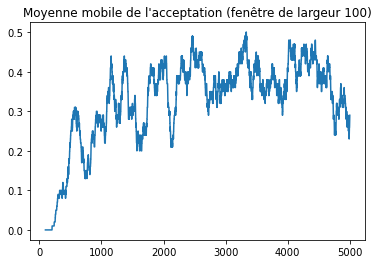

In [21]:
plt.plot(pd.DataFrame(acceptance_uniform_pi).rolling(100).mean().values)
plt.title("Moyenne mobile de l'acceptation (fenêtre de largeur 100)")
plt.show()

#### Dans le cas full-bayésien

In [22]:
SIGMA_INTERVAL=2*sigma_star

# likelihood p(x,sigma_2|data) [without constant]

def p_x_full_bayesian(x, sigma_2, date_end, bounds=BOUNDS): #bound on sigma_2 : positive
    T_end = (date_end - np.datetime64('2020-01-25')) / np.timedelta64(1, 'D')
    if x_is_between_bounds(x,bounds) and np.all(sigma_2>np.zeros(sigma_2.size)):
        x11=int(x[11])
        x12=int(x[12])
        T_end = (date_end - np.datetime64('2020-01-25')) / np.timedelta64(1, 'D')
        all_err,all_size=meta_error(x, date_end, x11, x12, T_end)
        all_err=all_err/sigma_2
        prod_sigma=np.prod(sigma_2**(-0.5*all_size))
        return prod_sigma*np.exp(-0.5*np.sum(all_err))
    else:
        return 0
    
#exploration law : gaussian
def law_gaussian_fb(y,sigma_2, diag=DIAG_INTERVAL, sigma_diag=SIGMA_INTERVAL):
    """ Size of y : x.size + sigma_2.size
    sigma_2_diag : scaling parameter"""
    diag_final=np.concatenate((diag,sigma_diag))
    return y+ np.sqrt(sigma_2*diag_final)*np.random.randn(y.size)

#exploration law : uniform
def law_uniform_fb(y,alpha, diag=DIAG_INTERVAL,sigma_diag=SIGMA_INTERVAL):
    diag_final=np.concatenate((diag,sigma_diag))
    return np.random.uniform(low=y-alpha*diag_final, high=y+alpha*diag_final)

def metropolis_hastings_full_bayesian(date_end,N,x0,sigma_2_0, method,diag=DIAG_INTERVAL, sigma_diag=SIGMA_INTERVAL,sigma_2_gaussian=3e-4, alpha_uniform=0.003,burn_in=0.4, thinning=0.2):
    """Return : the chain of x for the distribution,the chain of sigma_2 for the ditribution, the acceptance array
    param:
    N : nb of iterations
    x0 : starting point
    sigma_2_0 : array(5) :  starting point for sigma
    method : either 'gaussian' or 'uniform'
    diag : array(x0.size) : defines the scaling hyperparameter
    
    sigma_2_gaussian : float : used for scaling gaussian exploration law
    alpha_uniform : float : used for scaling uniform exploration law
    
    burning : float(0,1) : part of starting data not used finally
    thinning : float(0,1) : part of global data finally used 
    """
    x_sigma_chain=np.zeros((N,x0.size + sigma_2_0.size))
    acceptance=np.zeros(N-1)
    x_sigma_chain[0]=np.concatenate((x0,sigma_2_0))
    
    for n in range(N-1):
        if method=="gaussian":
            y_new=law_gaussian_fb(x_sigma_chain[n],sigma_2_gaussian, diag,sigma_diag)
        elif method=="uniform":
            y_new=law_uniform_fb(x_sigma_chain[n],alpha_uniform,diag, sigma_diag)
        y_new[11]=int(y_new[11])
        y_new[12]=int(y_new[12])
        u_sim=np.random.uniform()
        if u_sim <= p_x_full_bayesian(y_new[:x0.size], y_new[x0.size:], date_end)/p_x_full_bayesian(x_sigma_chain[n,:x0.size],x_sigma_chain[n,x0.size:], date_end):#loi symétrique
            x_sigma_chain[n+1]=y_new
            acceptance[n]=1
        else:
            x_sigma_chain[n+1]=x_sigma_chain[n]
    #burn_in
    
    x_sigma_chain=x_sigma_chain[int(burn_in*N):,:]
    
    #thinning
    
    x_sigma_chain=x_sigma_chain[::int(1/thinning),:] #we keep thinning*N (100*thinning percent)
    
    return x_sigma_chain[:,:x0.size],x_sigma_chain[:,x0.size:], acceptance


##### Exploration gaussienne

In [23]:
%%time
np.random.seed(0)
x_chain_gaussian_fb, sigma_chain_gaussian_fb, acceptance_gaussian_fb=metropolis_hastings_full_bayesian(
    DATE_END,
    N=5000,
    x0=x_star,
    sigma_2_0=sigma_star,
    method="gaussian",
    sigma_2_gaussian=2e-7
)
#np.save("result/Q11/x_chain_fb_gaussian", x_chain_gaussian_fb)
#np.save("result/Q11/acceptance_fb_gaussian", acceptance_gaussian_fb)
#np.save("result/Q11/sigma_chain_fb_gaussian", sigma_chain_gaussian_fb)

Wall time: 59.6 s


In [24]:
nb_points, size_param=x_chain_gaussian_fb.shape
print("Distribution de taille :", nb_points)

Distribution de taille : 600


In [25]:
print("Moyenne de l'acceptance:",np.round(np.mean(acceptance_gaussian_fb),decimals=4))

Moyenne de l'acceptance: 0.3407


In [26]:
plt.plot(pd.DataFrame(acceptance_gaussian_fb).rolling(100).mean().values)
plt.title("Moyenne mobile de l'acceptation (fenêtre de largeur 100)")
plt.show()

##### Exploration uniforme

In [27]:
%%time
np.random.seed(0)
x_chain_uniform_fb, sigma_chain_uniform_fb,acceptance_uniform_fb=metropolis_hastings_full_bayesian(DATE_END,N=5000,x0=x_star,sigma_2_0=sigma_star,method="uniform", alpha_uniform=9e-4)
#np.save("result/Q11/x_chain_fb_uniform", x_chain_uniform_fb)
#np.save("result/Q11/acceptance_fb_uniform", acceptance_uniform_fb)
#np.save("result/Q11/sigma_chain_fb_uniform", sigma_chain_uniform_fb)

Wall time: 59.5 s


In [28]:
nb_points, size_param=x_chain_uniform_fb.shape
print("Distribution de taille :", nb_points)

Distribution de taille : 600


In [29]:
print("Moyenne de l'acceptance:",np.round(np.mean(acceptance_uniform_fb),decimals=4))

Moyenne de l'acceptance: 0.3607


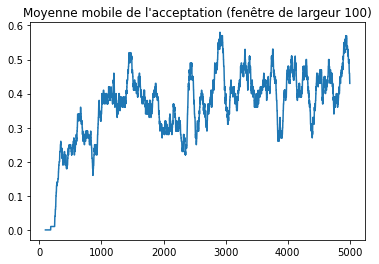

In [30]:
plt.plot(pd.DataFrame(acceptance_uniform_fb).rolling(100).mean().values)
plt.title("Moyenne mobile de l'acceptation (fenêtre de largeur 100)")
plt.show()

##### Posterior vs Prior (PI gaussien - PI uniforme - FB gaussien) : échantillons de taille 600

Nous faisons les mêmes analyses comme dans la question 10 afin de choisir les meilleurs paramètres pour le $x^*$ final. On remarque que les distributions sont beaucoup plus concentrées, ce qui veut dire que l'apprentissage est beaucoup plus précis.

Moyenne PRIOR :  0.6529 - Variance PRIOR :  0.01977

PI : Moyenne POST (gaussian) :  0.896 - PI : Variance POST (gaussian):  0.0
PI : Moyenne POST (uniform) :  0.8852 - PI : Variance POST (uniform):  5e-05

FB : Moyenne POST (gaussian) :  0.886 - FB : Variance POST (gaussian):  5e-05
FB : Moyenne POST (uniform) :  0.8989 - FB : Variance POST (uniform):  0.0
-----------------------------------------------------------------------------------------------


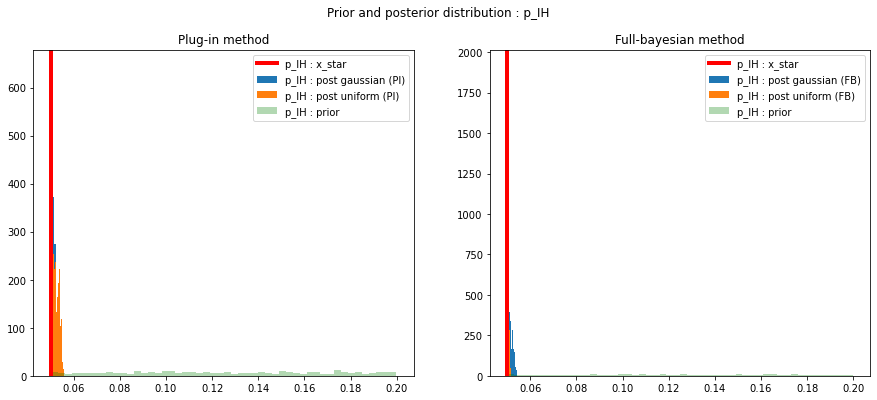

Moyenne PRIOR :  0.1255 - Variance PRIOR :  0.00182

PI : Moyenne POST (gaussian) :  0.0515 - PI : Variance POST (gaussian):  0.0
PI : Moyenne POST (uniform) :  0.0523 - PI : Variance POST (uniform):  0.0

FB : Moyenne POST (gaussian) :  0.0517 - FB : Variance POST (gaussian):  0.0
FB : Moyenne POST (uniform) :  0.0505 - FB : Variance POST (uniform):  0.0
-----------------------------------------------------------------------------------------------


Moyenne PRIOR :  0.0249 - Variance PRIOR :  7e-05

PI : Moyenne POST (gaussian) :  0.0118 - PI : Variance POST (gaussian):  0.0
PI : Moyenne POST (uniform) :  0.0111 - PI : Variance POST (uniform):  0.0

FB : Moyenne POST (gaussian) :  0.0126 - FB : Variance POST (gaussian):  0.0
FB : Moyenne POST (uniform) :  0.0113 - FB : Variance POST (uniform):  0.0
-----------------------------------------------------------------------------------------------


Moyenne PRIOR :  0.1497 - Variance PRIOR :  0.00084

PI : Moyenne POST (gaussian) :  0.1892 - PI : Variance POST (gaussian):  0.0
PI : Moyenne POST (uniform) :  0.1866 - PI : Variance POST (uniform):  1e-05

FB : Moyenne POST (gaussian) :  0.1755 - FB : Variance POST (gaussian):  1e-05
FB : Moyenne POST (uniform) :  0.1864 - FB : Variance POST (uniform):  0.0
-----------------------------------------------------------------------------------------------


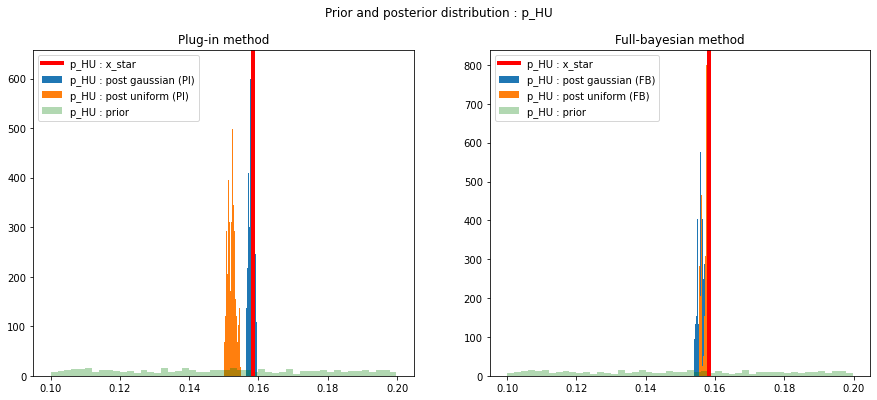

Moyenne PRIOR :  0.1489 - Variance PRIOR :  0.00084

PI : Moyenne POST (gaussian) :  0.1578 - PI : Variance POST (gaussian):  0.0
PI : Moyenne POST (uniform) :  0.1523 - PI : Variance POST (uniform):  0.0

FB : Moyenne POST (gaussian) :  0.1559 - FB : Variance POST (gaussian):  0.0
FB : Moyenne POST (uniform) :  0.1572 - FB : Variance POST (uniform):  0.0
-----------------------------------------------------------------------------------------------


Moyenne PRIOR :  0.3003 - Variance PRIOR :  0.0033

PI : Moyenne POST (gaussian) :  0.3414 - PI : Variance POST (gaussian):  0.0
PI : Moyenne POST (uniform) :  0.3378 - PI : Variance POST (uniform):  5e-05

FB : Moyenne POST (gaussian) :  0.3481 - FB : Variance POST (gaussian):  1e-05
FB : Moyenne POST (uniform) :  0.3404 - FB : Variance POST (uniform):  0.0
-----------------------------------------------------------------------------------------------


Moyenne PRIOR :  10.0026 - Variance PRIOR :  1.38727

PI : Moyenne POST (gaussian) :  8.0121 - PI : Variance POST (gaussian):  2e-05
PI : Moyenne POST (uniform) :  8.1729 - PI : Variance POST (uniform):  0.00591

FB : Moyenne POST (gaussian) :  8.0219 - FB : Variance POST (gaussian):  5e-05
FB : Moyenne POST (uniform) :  8.0695 - FB : Variance POST (uniform):  0.00034
-----------------------------------------------------------------------------------------------


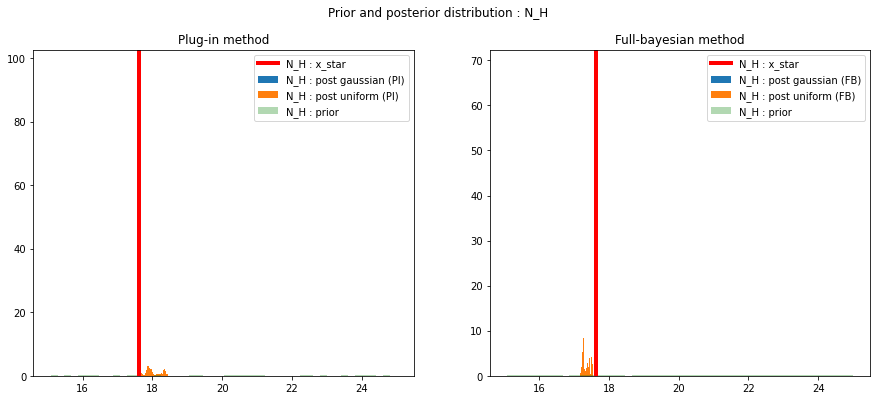

Moyenne PRIOR :  19.9711 - Variance PRIOR :  8.72727

PI : Moyenne POST (gaussian) :  17.6257 - PI : Variance POST (gaussian):  9e-05
PI : Moyenne POST (uniform) :  17.9999 - PI : Variance POST (uniform):  0.0554

FB : Moyenne POST (gaussian) :  17.5977 - FB : Variance POST (gaussian):  0.00016
FB : Moyenne POST (uniform) :  17.3649 - FB : Variance POST (uniform):  0.01271
-----------------------------------------------------------------------------------------------


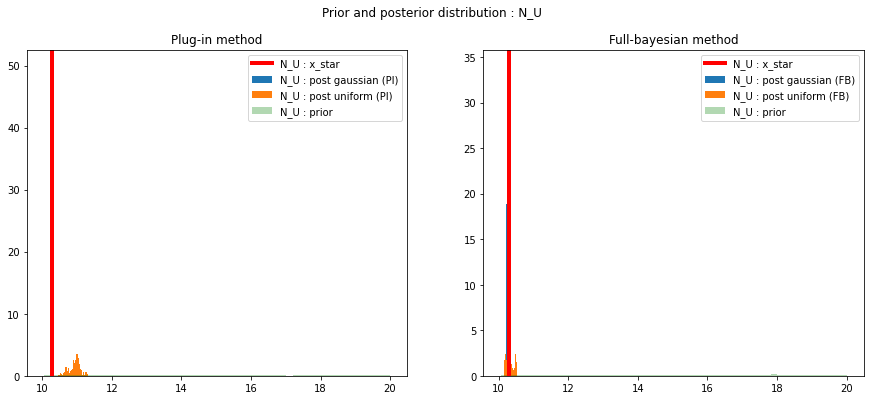

Moyenne PRIOR :  15.059 - Variance PRIOR :  8.43574

PI : Moyenne POST (gaussian) :  10.2693 - PI : Variance POST (gaussian):  0.00015
PI : Moyenne POST (uniform) :  10.9346 - PI : Variance POST (uniform):  0.03109

FB : Moyenne POST (gaussian) :  10.2307 - FB : Variance POST (gaussian):  0.00024
FB : Moyenne POST (uniform) :  10.3062 - FB : Variance POST (uniform):  0.00657
-----------------------------------------------------------------------------------------------


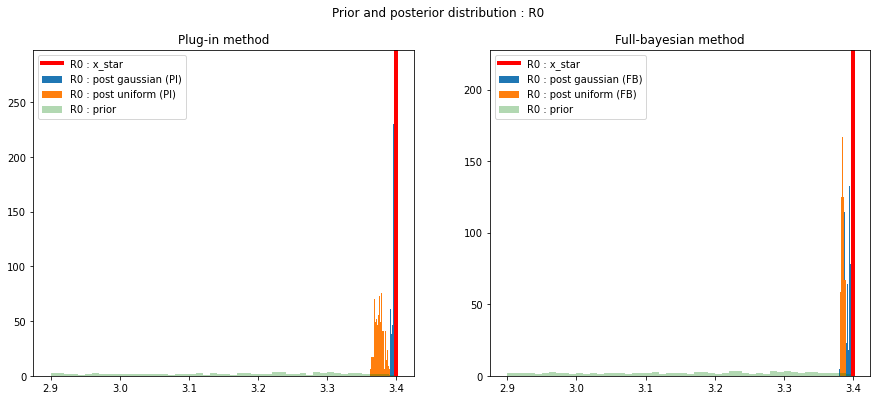

Moyenne PRIOR :  3.1598 - Variance PRIOR :  0.02073

PI : Moyenne POST (gaussian) :  3.396 - PI : Variance POST (gaussian):  1e-05
PI : Moyenne POST (uniform) :  3.3748 - PI : Variance POST (uniform):  4e-05

FB : Moyenne POST (gaussian) :  3.39 - FB : Variance POST (gaussian):  2e-05
FB : Moyenne POST (uniform) :  3.3851 - FB : Variance POST (uniform):  0.0
-----------------------------------------------------------------------------------------------


Moyenne PRIOR :  0.0461 - Variance PRIOR :  0.0004

PI : Moyenne POST (gaussian) :  0.0259 - PI : Variance POST (gaussian):  0.0
PI : Moyenne POST (uniform) :  0.0218 - PI : Variance POST (uniform):  0.0

FB : Moyenne POST (gaussian) :  0.0265 - FB : Variance POST (gaussian):  0.0
FB : Moyenne POST (uniform) :  0.0192 - FB : Variance POST (uniform):  0.0
-----------------------------------------------------------------------------------------------


Moyenne PRIOR :  38.7117 - Variance PRIOR :  28.5652

PI : Moyenne POST (gaussian) :  30.0 - PI : Variance POST (gaussian):  0.0
PI : Moyenne POST (uniform) :  30.0 - PI : Variance POST (uniform):  0.0

FB : Moyenne POST (gaussian) :  30.0 - FB : Variance POST (gaussian):  0.0
FB : Moyenne POST (uniform) :  30.0 - FB : Variance POST (uniform):  0.0
-----------------------------------------------------------------------------------------------


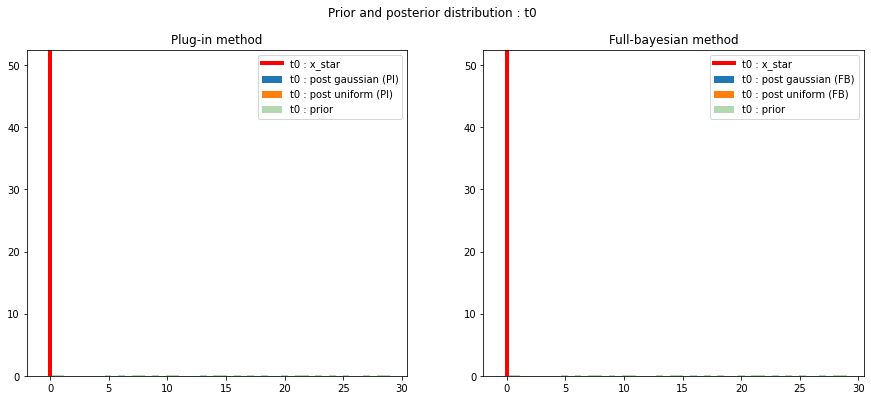

Moyenne PRIOR :  14.9067 - Variance PRIOR :  72.44462

PI : Moyenne POST (gaussian) :  0.0 - PI : Variance POST (gaussian):  0.0
PI : Moyenne POST (uniform) :  0.0 - PI : Variance POST (uniform):  0.0

FB : Moyenne POST (gaussian) :  0.0 - FB : Variance POST (gaussian):  0.0
FB : Moyenne POST (uniform) :  0.0 - FB : Variance POST (uniform):  0.0
-----------------------------------------------------------------------------------------------


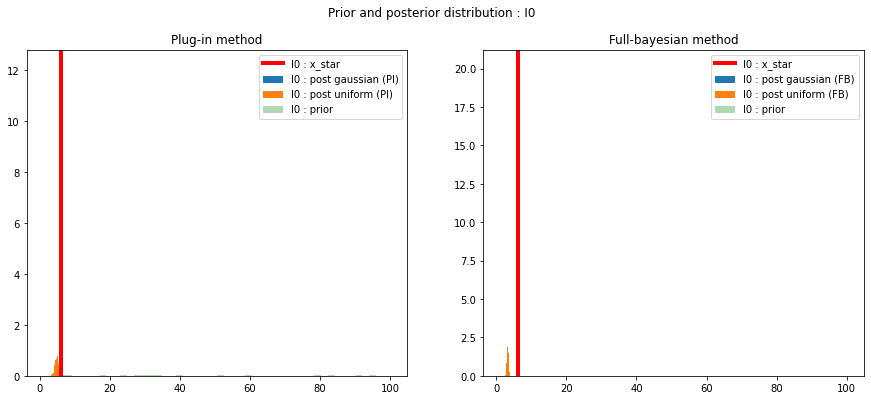

Moyenne PRIOR :  49.5797 - Variance PRIOR :  796.49774

PI : Moyenne POST (gaussian) :  6.1112 - PI : Variance POST (gaussian):  0.00225
PI : Moyenne POST (uniform) :  4.8313 - PI : Variance POST (uniform):  0.34476

FB : Moyenne POST (gaussian) :  6.1747 - FB : Variance POST (gaussian):  0.00068
FB : Moyenne POST (uniform) :  3.2277 - FB : Variance POST (uniform):  0.06041
-----------------------------------------------------------------------------------------------


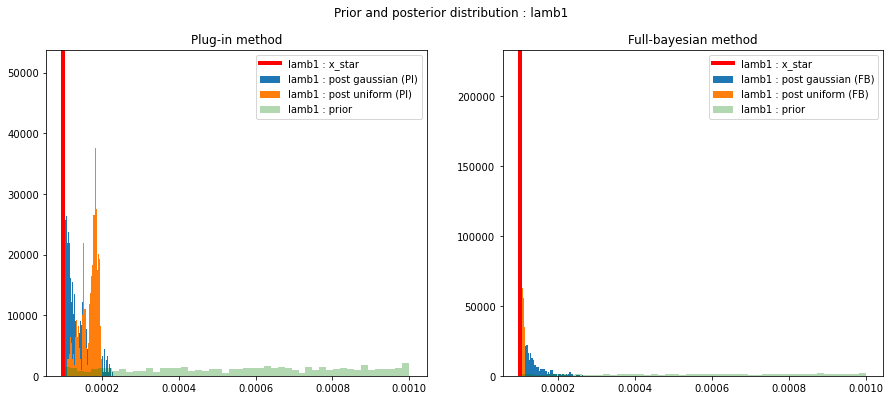

Moyenne PRIOR :  0.0006 - Variance PRIOR :  0.0

PI : Moyenne POST (gaussian) :  0.0001 - PI : Variance POST (gaussian):  0.0
PI : Moyenne POST (uniform) :  0.0002 - PI : Variance POST (uniform):  0.0

FB : Moyenne POST (gaussian) :  0.0001 - FB : Variance POST (gaussian):  0.0
FB : Moyenne POST (uniform) :  0.0001 - FB : Variance POST (uniform):  0.0
-----------------------------------------------------------------------------------------------


In [31]:
LABELS=["p_a","p_IH","p_IU","p_HD","p_HU","p_UD","N_I","N_H","N_U","R0","mu","N","t0","I0","lamb1"]

for i in range(x_chain_gaussian_pi[0].size):
    bounds_i=BOUNDS[i]
    if i!=11 and i!=12:
        uniform_reference=np.random.uniform(low=bounds_i[0], high=bounds_i[1],size=np.size(x_chain_gaussian_pi[:,0]))
        
    else:
        uniform_reference=np.random.randint(low=int(bounds_i[0]), high=int(bounds_i[1]),size=np.size(x_chain_gaussian_pi[:,0]))
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,6))
    fig.suptitle("Prior and posterior distribution : "+LABELS[i])
    ax1.hist(x_chain_gaussian_pi[:,i], density=True, bins=50, label=LABELS[i]+" : post gaussian (PI)")
    ax1.hist(x_chain_uniform_pi[:,i], density=True, bins=50, label=LABELS[i]+" : post uniform (PI)")
    ax1.hist(uniform_reference, density=True, bins=50, alpha=0.3,label=LABELS[i]+" : prior",color="green")
    ax1.axvline(x=x_star[i],linewidth=4, color='r', label=LABELS[i]+ " : x_star")
    ax1.set_title("Plug-in method")
    ax1.legend()
    ax2.hist(x_chain_gaussian_fb[:,i], density=True, bins=50, label=LABELS[i]+" : post gaussian (FB)")
    ax2.hist(x_chain_uniform_fb[:,i], density=True, bins=50, label=LABELS[i]+" : post uniform (FB)")
    ax2.hist(uniform_reference, density=True, bins=50, alpha=0.3,label=LABELS[i]+" : prior", color="green")
    ax2.axvline(x=x_star[i],linewidth=4, color='r', label=LABELS[i]+ " : x_star")
    ax2.set_title("Full-bayesian method")
    ax2.legend()
    plt.show()
    print("Moyenne PRIOR : ",np.round(np.mean(uniform_reference),decimals=4), "- Variance PRIOR : ",np.round(np.var(uniform_reference),decimals=5))
    print("")
    print("PI : Moyenne POST (gaussian) : ",np.round(np.mean(x_chain_gaussian_pi[:,i]),decimals=4),"- PI : Variance POST (gaussian): ",np.round(np.var(x_chain_gaussian_pi[:,i]),decimals=5))
    print("PI : Moyenne POST (uniform) : ",np.round(np.mean(x_chain_uniform_pi[:,i]),decimals=4),"- PI : Variance POST (uniform): ",np.round(np.var(x_chain_uniform_pi[:,i]),decimals=5))
    print("")
    print("FB : Moyenne POST (gaussian) : ",np.round(np.mean(x_chain_gaussian_fb[:,i]),decimals=4),"- FB : Variance POST (gaussian): ",np.round(np.var(x_chain_gaussian_fb[:,i]),decimals=5))
    print("FB : Moyenne POST (uniform) : ",np.round(np.mean(x_chain_uniform_fb[:,i]),decimals=4),"- FB : Variance POST (uniform): ",np.round(np.var(x_chain_uniform_fb[:,i]),decimals=5))
    print("-----------------------------------------------------------------------------------------------")

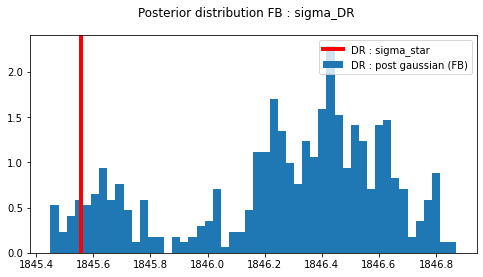

Sigma_star :  1845.555679432078
FB : Moyenne POST (gaussian) :  1846.2629 - FB : Variance POST (gaussian):  0.13056
FB : Moyenne POST (uniform) :  1763.8526 - FB : Variance POST (uniform):  898.14513


Sigma_star :  7645.661930768919
FB : Moyenne POST (gaussian) :  7646.1762 - FB : Variance POST (gaussian):  0.43218
FB : Moyenne POST (uniform) :  7680.1926 - FB : Variance POST (uniform):  7141.65687


Sigma_star :  1713.841079008539
FB : Moyenne POST (gaussian) :  1713.6747 - FB : Variance POST (gaussian):  0.05222
FB : Moyenne POST (uniform) :  1707.0763 - FB : Variance POST (uniform):  500.35466


Sigma_star :  2678.472891529937
FB : Moyenne POST (gaussian) :  2678.2082 - FB : Variance POST (gaussian):  0.05044
FB : Moyenne POST (uniform) :  2532.2166 - FB : Variance POST (uniform):  1381.54862


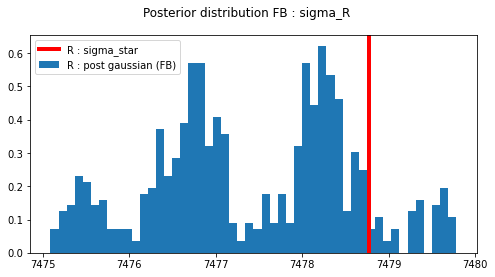

Sigma_star :  7478.768421099104
FB : Moyenne POST (gaussian) :  7477.4084 - FB : Variance POST (gaussian):  1.29932
FB : Moyenne POST (uniform) :  7726.3104 - FB : Variance POST (uniform):  19225.7511


In [32]:
LABELS_SIGMA=["DR","H","U","D","R"]
for i in range(sigma_chain_gaussian_fb[0].size):
    fig, (ax1) = plt.subplots(figsize=(8,4))
    fig.suptitle("Posterior distribution FB : sigma_"+LABELS_SIGMA[i])
    ax1.hist(sigma_chain_gaussian_fb[:,i], density=True, bins=50, label=LABELS_SIGMA[i]+" : post gaussian (FB)")
    ax1.axvline(x=sigma_star[i],linewidth=4, color='r', label=LABELS_SIGMA[i]+ " : sigma_star")
    #ax1.hist(sigma_chain_uniform_fb[:,i], density=True, bins=50, label=LABELS_SIGMA[i]+" : post uniform (FB)")
    ax1.legend()
    plt.show()
    print("Sigma_star : ", sigma_star[i])
    print("FB : Moyenne POST (gaussian) : ",np.round(np.mean(sigma_chain_gaussian_fb[:,i]),decimals=4),"- FB : Variance POST (gaussian): ",np.round(np.var(sigma_chain_gaussian_fb[:,i]),decimals=5))
    print("FB : Moyenne POST (uniform) : ",np.round(np.mean(sigma_chain_uniform_fb[:,i]),decimals=4),"- FB : Variance POST (uniform): ",np.round(np.var(sigma_chain_uniform_fb[:,i]),decimals=5))

### Résultats sur l'incertitude des paramètres et la prédiction (Plug-in gaussien)

On gagne en certitude sur tous les paramètres.

La date du début de l'épidémie:  2020-01-25
La fin de simulation:  2020-05-11
Le nombre maximal de patients détectés : 11131.242469225162
La date où on détecte le plus de patients : 2020-04-11


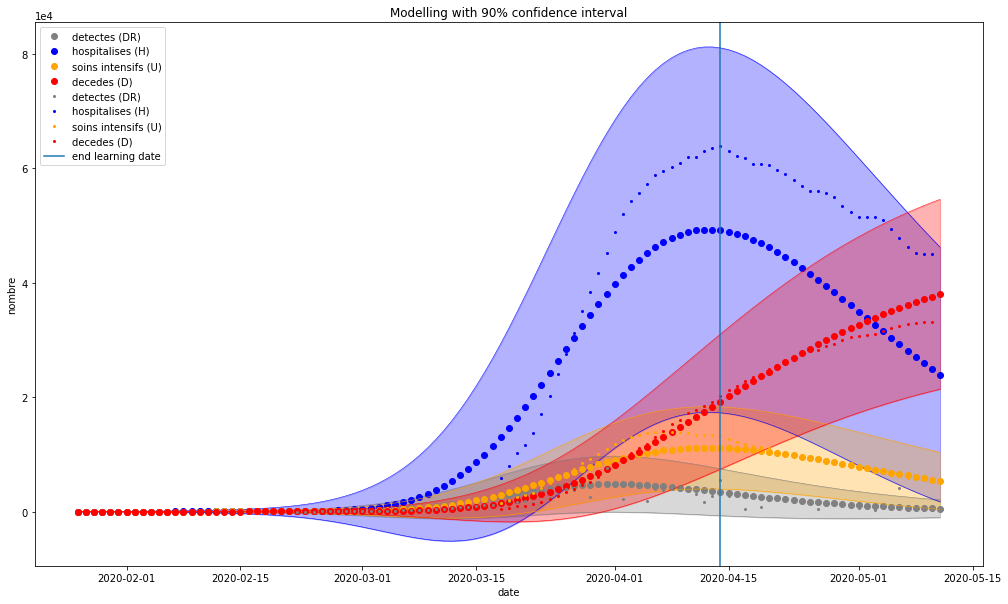

In [33]:
ALPHA=0.05
import scipy.stats as stats

quantile_alpha=stats.norm.ppf(1-ALPHA)

params = x_star
params[0]=0.896
params[1]=0.0515
params[2]=0.0118
params[3]=0.1892
params[4]=0.1578
params[5]=0.3414
params[6] = 8.01
params[7] = 17.63
params[8]=10.26
params[9]=3.396
params[10] = 0.0259
params[11] = 30
params[12] = 0
params[13] = 6.11
params[14] = 0

model.reset(params)

import matplotlib.pyplot as plt
sol = model.evolution_T(True)
nb_maximum, date_maximum = model.soins_intensifs()
print("Le nombre maximal de patients détectés : {}".format(nb_maximum))
print("La date où on détecte le plus de patients : {}".format(model.d0 + np.timedelta64(int(date_maximum), 'D')))
plt.figure(figsize=(17, 10))
indices = [9, 5, 6, 8]
labels = ["detectes (DR)", "hospitalises (H)", "soins intensifs (U)", "decedes (D)"]
for i in range(4):
    plt.plot_date(model.d0 + np.timedelta64(1, 'D') * sol.t, sol.y[indices[i], :], label=labels[i],color=COLORS_PLOT[i])
    y_i_plus= sol.y[indices[i], :] +np.sqrt(sol.y[indices[i], :]*sigma_star[i])*quantile_alpha
    y_i_minus= sol.y[indices[i], :] -np.sqrt(sol.y[indices[i], :]*sigma_star[i])*quantile_alpha
    plt.plot_date(model.d0 + np.timedelta64(1, 'D') * sol.t,y_i_plus , color=COLORS_PLOT[i],linestyle='-',linewidth=0.5,markersize=0)
    plt.plot_date(model.d0 + np.timedelta64(1, 'D') * sol.t,y_i_minus, color=COLORS_PLOT[i],linestyle='-',linewidth=0.5,markersize=0)
    plt.fill_between(model.d0 + np.timedelta64(1, 'D') * sol.t, y_i_plus, y_i_minus, color=COLORS_PLOT[i], alpha=0.3)
    
plt.legend(loc="upper left")
plt.xlabel("date")
plt.ylabel("nombre")
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

plt.plot_date(data_nb_cumule.date, data_nb_cumule.nbre, label='detectes (DR)', markersize=2,color=COLORS_PLOT[0])
plt.plot_date(data_hospital.date, data_hospital.hosp, label='hospitalises (H)', markersize=2,color=COLORS_PLOT[1])
plt.plot_date(data_hospital.date, data_hospital.rea, label='soins intensifs (U)', markersize=2,color=COLORS_PLOT[2])
plt.plot_date(data_hospital.date, data_hospital.dc, label='decedes (D)', markersize=2,color=COLORS_PLOT[3])
plt.axvline(np.datetime64('2020-04-14'), label='end learning date')
plt.legend(loc="upper left")
plt.xlabel("date")
plt.ylabel("nombre")
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.title("Modelling with 90% confidence interval")
plt.savefig("result/Q11/forecasting_second_learning_plug_in_gaussian.png")
plt.show()

### Résultats sur l'incertitude des paramètres et la prédiction (Plug-in uniforme)

On gagne en certitude sur tous les paramètres.

La date du début de l'épidémie:  2020-01-25
La fin de simulation:  2020-05-11
Le nombre maximal de patients détectés : 13896.817155185863
La date où on détecte le plus de patients : 2020-04-16


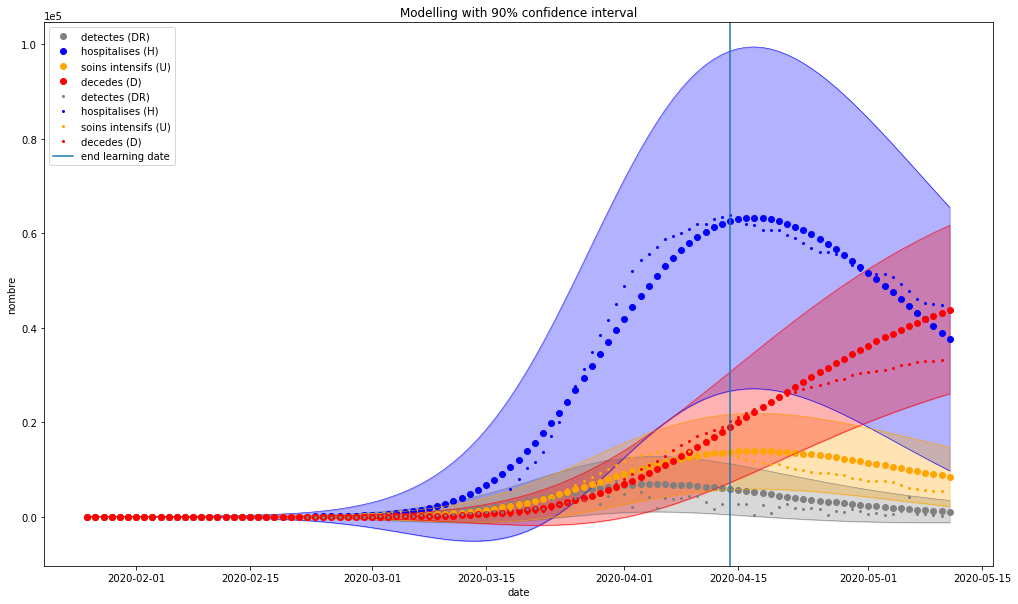

In [43]:
ALPHA=0.05
import scipy.stats as stats

quantile_alpha=stats.norm.ppf(1-ALPHA)

params = x_star
params[0]=0.885
params[1]=0.0523
params[2]=0.0111
params[3]=0.1866
params[4]=0.1523
params[5]=0.33
params[6] = 8.15
params[7] = 17.99
params[8]=10.93
params[9]=3.374
params[10] = 0.0218
params[11] = 30
params[12] = 0
params[13] = 4.8
params[14] = 0.00015

model.reset(params)

import matplotlib.pyplot as plt
sol = model.evolution_T(True)
nb_maximum, date_maximum = model.soins_intensifs()
print("Le nombre maximal de patients détectés : {}".format(nb_maximum))
print("La date où on détecte le plus de patients : {}".format(model.d0 + np.timedelta64(int(date_maximum), 'D')))
plt.figure(figsize=(17, 10))
indices = [9, 5, 6, 8]
labels = ["detectes (DR)", "hospitalises (H)", "soins intensifs (U)", "decedes (D)"]
for i in range(4):
    plt.plot_date(model.d0 + np.timedelta64(1, 'D') * sol.t, sol.y[indices[i], :], label=labels[i],color=COLORS_PLOT[i])
    y_i_plus= sol.y[indices[i], :] +np.sqrt(sol.y[indices[i], :]*sigma_star[i])*quantile_alpha
    y_i_minus= sol.y[indices[i], :] -np.sqrt(sol.y[indices[i], :]*sigma_star[i])*quantile_alpha
    plt.plot_date(model.d0 + np.timedelta64(1, 'D') * sol.t,y_i_plus , color=COLORS_PLOT[i],linestyle='-',linewidth=0.5,markersize=0)
    plt.plot_date(model.d0 + np.timedelta64(1, 'D') * sol.t,y_i_minus, color=COLORS_PLOT[i],linestyle='-',linewidth=0.5,markersize=0)
    plt.fill_between(model.d0 + np.timedelta64(1, 'D') * sol.t, y_i_plus, y_i_minus, color=COLORS_PLOT[i], alpha=0.3)
    
plt.legend(loc="upper left")
plt.xlabel("date")
plt.ylabel("nombre")
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

plt.plot_date(data_nb_cumule.date, data_nb_cumule.nbre, label='detectes (DR)', markersize=2,color=COLORS_PLOT[0])
plt.plot_date(data_hospital.date, data_hospital.hosp, label='hospitalises (H)', markersize=2,color=COLORS_PLOT[1])
plt.plot_date(data_hospital.date, data_hospital.rea, label='soins intensifs (U)', markersize=2,color=COLORS_PLOT[2])
plt.plot_date(data_hospital.date, data_hospital.dc, label='decedes (D)', markersize=2,color=COLORS_PLOT[3])
plt.axvline(np.datetime64('2020-04-14'), label='end learning date')
plt.legend(loc="upper left")
plt.xlabel("date")
plt.ylabel("nombre")
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.title("Modelling with 90% confidence interval")
plt.savefig("forecasting_second_learning_plug_in_uniform.png")
plt.show()

### Résultats sur l'incertitude des paramètres et la prédiction (Full bayesian gaussien)

On gagne en certitude sur tous les paramètres.

La date du début de l'épidémie:  2020-01-25
La fin de simulation:  2020-05-11
Le nombre maximal de patients détectés : 14298.69538757783
La date où on détecte le plus de patients : 2020-04-17


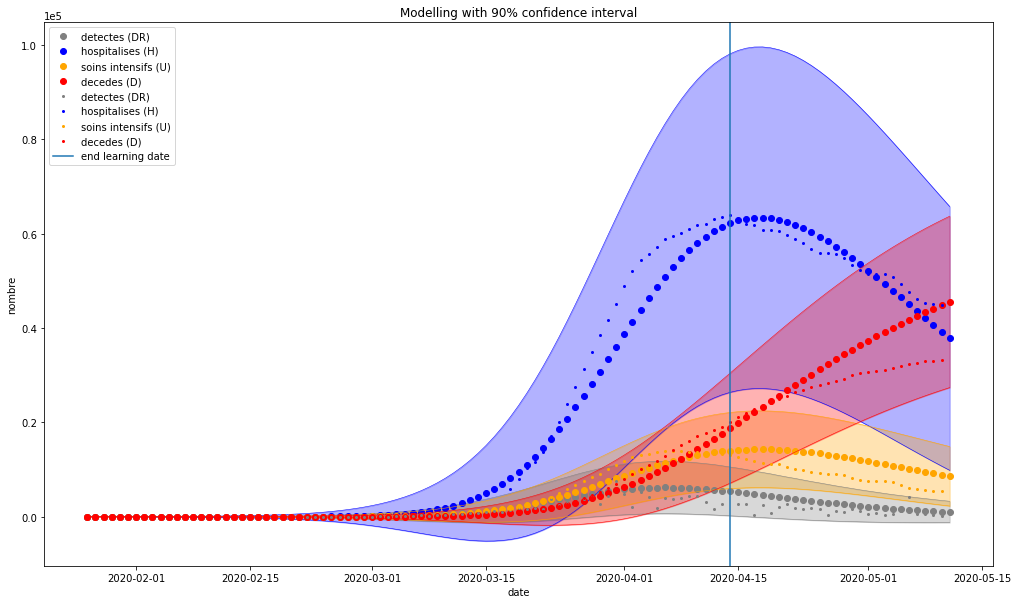

In [39]:
ALPHA=0.05
import scipy.stats as stats

quantile_alpha=stats.norm.ppf(1-ALPHA)

params = x_star
params[0]=0.8989
params[1]=0.0505
params[2]=0.0113
params[3]=0.1864
params[4]=0.1572
params[5]=0.34
params[6] = 8.07
params[7] = 17.36
params[8]=10.3
params[9]=3.38
params[10] = 0.0192
params[11] = 30
params[12] = 0
params[13] = 3.22
params[14] = 0

sigma_bayesian=np.zeros(5)
sigma_bayesian[0]=1844.45
sigma_bayesian[1]=7646.3
sigma_bayesian[2]=1713.7
sigma_bayesian[3]=2678.1
sigma_bayesian[4]=7478.25

model.reset(params)

import matplotlib.pyplot as plt
sol = model.evolution_T(True)
nb_maximum, date_maximum = model.soins_intensifs()
print("Le nombre maximal de patients détectés : {}".format(nb_maximum))
print("La date où on détecte le plus de patients : {}".format(model.d0 + np.timedelta64(int(date_maximum), 'D')))
plt.figure(figsize=(17, 10))
indices = [9, 5, 6, 8]
labels = ["detectes (DR)", "hospitalises (H)", "soins intensifs (U)", "decedes (D)"]
for i in range(4):
    plt.plot_date(model.d0 + np.timedelta64(1, 'D') * sol.t, sol.y[indices[i], :], label=labels[i],color=COLORS_PLOT[i])
    y_i_plus= sol.y[indices[i], :] +np.sqrt(sol.y[indices[i], :]*sigma_star[i])*quantile_alpha
    y_i_minus= sol.y[indices[i], :] -np.sqrt(sol.y[indices[i], :]*sigma_star[i])*quantile_alpha
    plt.plot_date(model.d0 + np.timedelta64(1, 'D') * sol.t,y_i_plus , color=COLORS_PLOT[i],linestyle='-',linewidth=0.5,markersize=0)
    plt.plot_date(model.d0 + np.timedelta64(1, 'D') * sol.t,y_i_minus, color=COLORS_PLOT[i],linestyle='-',linewidth=0.5,markersize=0)
    plt.fill_between(model.d0 + np.timedelta64(1, 'D') * sol.t, y_i_plus, y_i_minus, color=COLORS_PLOT[i], alpha=0.3)
    
plt.legend(loc="upper left")
plt.xlabel("date")
plt.ylabel("nombre")
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

plt.plot_date(data_nb_cumule.date, data_nb_cumule.nbre, label='detectes (DR)', markersize=2,color=COLORS_PLOT[0])
plt.plot_date(data_hospital.date, data_hospital.hosp, label='hospitalises (H)', markersize=2,color=COLORS_PLOT[1])
plt.plot_date(data_hospital.date, data_hospital.rea, label='soins intensifs (U)', markersize=2,color=COLORS_PLOT[2])
plt.plot_date(data_hospital.date, data_hospital.dc, label='decedes (D)', markersize=2,color=COLORS_PLOT[3])
plt.axvline(np.datetime64('2020-04-14'), label='end learning date')
plt.legend(loc="upper left")
plt.xlabel("date")
plt.ylabel("nombre")
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.title("Modelling with 90% confidence interval")
plt.show()

## CONCLUSION

La méthode plug-in uniforme fournit un modèle extrêmemnt proche des données réelles, même si elle sous-estime légèrement le nombre de personnes décédées. Les tendances liées au confinement sont assez bien captées à la fois sur l'apprentissage et sur la prédiction.

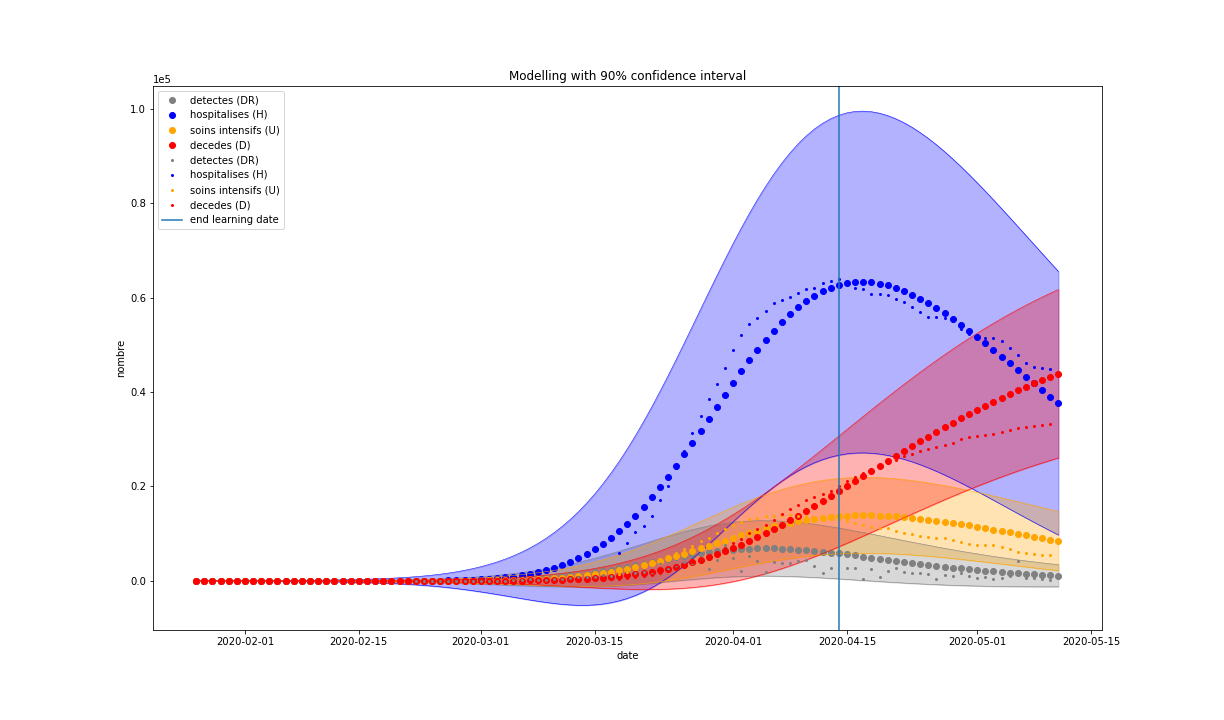

In [44]:
from IPython.display import Image
Image(filename="forecasting_second_learning_plug_in_uniform.png") 

à comparer avec 2 semaines en moins sur l'apprentissage (modèle affiché ci-dessous)

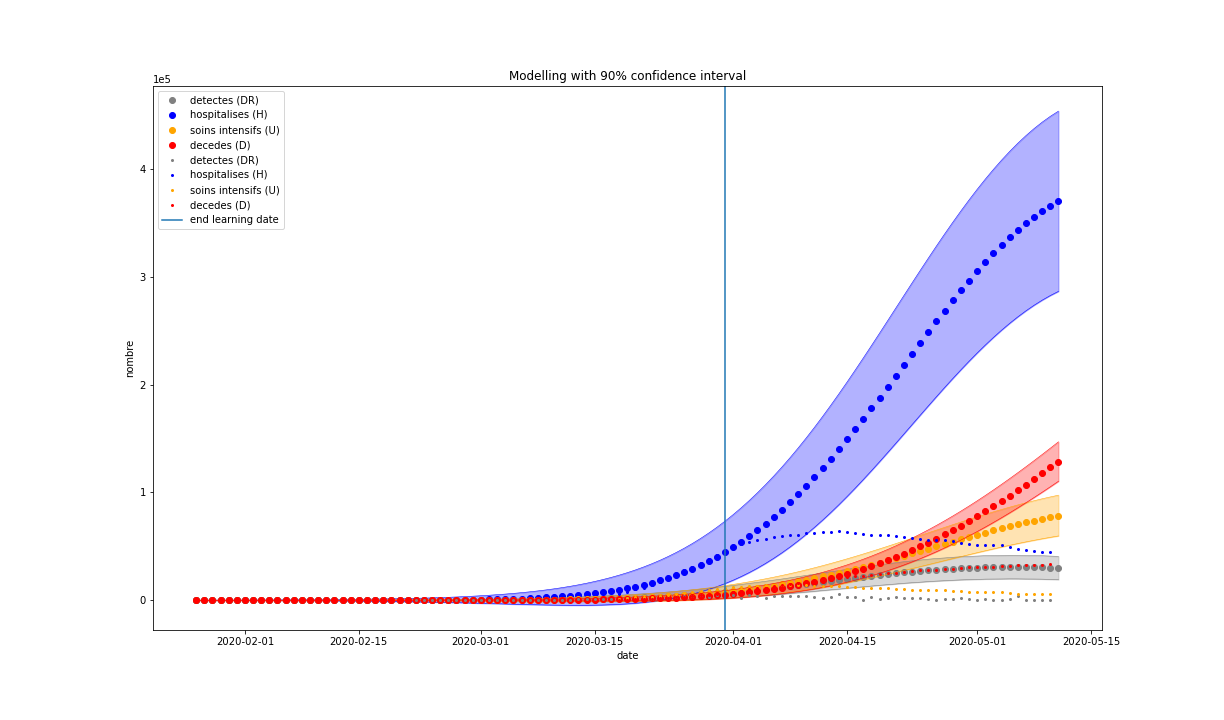

In [45]:
from IPython.display import Image
Image(filename="forecasting_first_learning_plug_in_uniform.png") 